In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT
import OperatorTools as OT
import GridTransferTools as GTT
import TestTools as TT
import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 8
refRatio = 2
c = 1.
CFL = 0.5
nt = 14
RK = 1
deriv = 'U'

In [3]:
if (RK == 1):
    TimeIntegratorFunc = ST.ForwardEuler
else:
    if (RK == 2):
        TimeIntegratorFunc = ST.MidpointMeth
    else:
        TimeIntegratorFunc = ST.RK4

if (deriv == 'U'):
    DiffMatFunc = OT.Upwind1D
    DiffFunc = ST.Upwind
else:
    DiffMatFunc = OT.CenterDiff1D
    DiffFunc = ST.CenterDiff

In [4]:
omega = BT.Grid(nh)
finehalf = list(np.arange(int(nh / refRatio)) + int(nh / refRatio))
omega.AddPatch(refRatio, finehalf)
degFreed = omega.degFreed
nh_min = omega.nh_min
nh_max = omega.nh_max
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
derivMat = DiffMatFunc(omega)
spatOp = -c * derivMat
timePropOp = LA2.expm(t * spatOp)
waves = WT.MakeWaves(omega)
print('')

[-1.         -1.         -1.         -0.66666667 -1.         -1.         -1.         -1.         -1.         -1.         -1.         -0.5       ]
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0. ]
[[ 8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 16.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 16.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 16.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 16.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 16.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 16.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 16.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 16.]]

[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.         -0.5        -0.5       ]
 [-1.          1.          0.  

In [5]:
print('derivMat =\n', derivMat, '\n')
print('spatOp =\n', spatOp, '\n')
print('timePropOp =\n', timePropOp, '\n')

derivMat =
 [[  8.           0.           0.           0.           0.           0.           0.           0.           0.           0.          -4.          -4.        ]
 [ -8.           8.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.          -8.           8.           0.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.          -8.           8.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         -10.66666667  10.66666667   0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         -16.          16.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.  

In [6]:
restrictOp = GTT.CoarsenOp(omega)

nullspace = OT.FindNullspace(omega, waves)

x = np.linspace(0, 1, num = nh_max + 1)[:-1] + (1. / (2. * nh_max))
sqStart = int(nh_max / 8)
sqEnd = int((2 * nh_max) / 8)
print(sqStart, sqEnd)
waveform = np.zeros(nh_max, float)
waveform[sqStart:sqEnd] = 1
# waveform = x - 0.5


print(x)
print(waveform)

# FCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)
# # # FCoefs[1::2] = 0
# waveform = waves @ nullspace @ FCoefs
propFCoefs = FFTT.PropRestrictWaves(omega, waveform, c, t)
waveform = restrictOp @ waveform
FCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)

solverCoefs = TimeIntegratorFunc(omega, waves @ nullspace, waveform, nt, c, CFL, DiffFunc)
exTimeForm = timePropOp @ waveform
exTimeCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, exTimeForm)
# solverCoefs2 = TimeIntegratorFunc(omega, waves @ nullspace, waveform, nt, c, CFL, TT.Upwind)


# propFCoefs = FFTT.PropogateFCoefs(omega, FCoefs, c, t)
labels = [r'$u_{0} (x)$', r'Exact $u_{0} (x - c t)$', r'Exact Time $u_{0} (x - c t)$', r'Time Integrator $u_{0} (x - c t)$']
allCoefs = PT.Load(FCoefs, propFCoefs, exTimeCoefs, solverCoefs)


2 4
[0.03125 0.09375 0.15625 0.21875 0.28125 0.34375 0.40625 0.46875 0.53125 0.59375 0.65625 0.71875 0.78125 0.84375 0.90625 0.96875]
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Start:
[1.         1.         1.         1.         0.66666667 1.         1.         1.         1.         1.         1.         1.        ]
[0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[0.5        1.         1.         1.         0.66666667 1.         1.         1.         1.         1.         1.         1.        ]
[0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]

[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
[0.0625 0.0625 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


Start:
[1.         1.         1.         1.         0.66666667 1.         1.         1.         1.         1.         1.         1.        ]
[0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]



Are you *sure* your labels are ordered correctly?


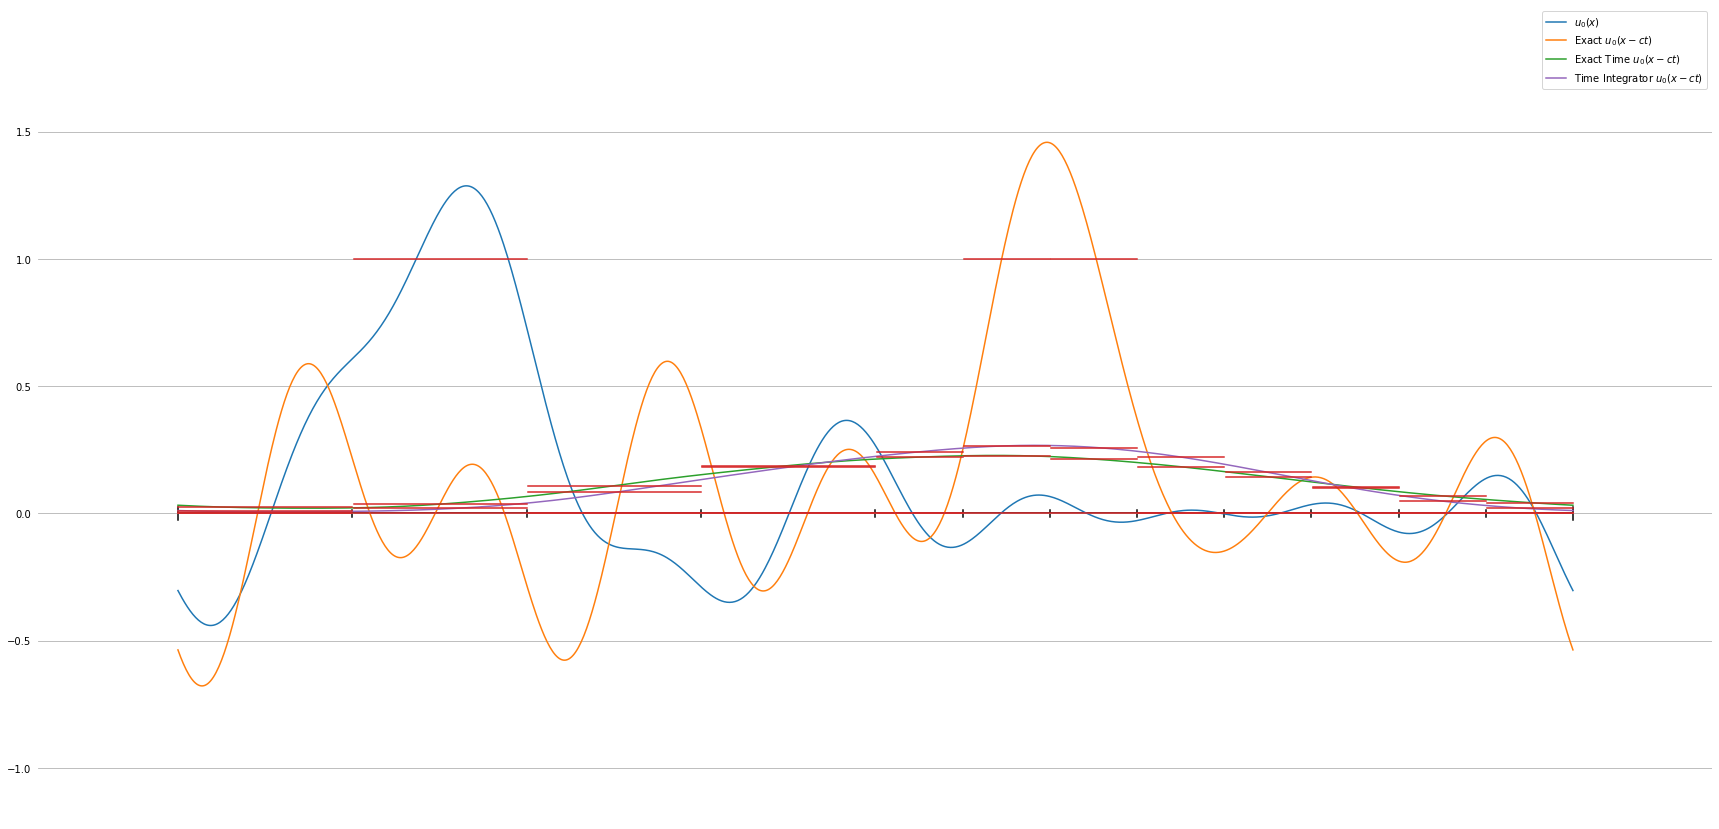

In [7]:
PT.PlotMixedWave(omega, waves, nullspace @ allCoefs, rescale = 6, labels = labels, yGrid = True, dpi = 300)


5
5
5
5
actual:
[5.31595754e-03 3.15823357e-04 1.13951689e-05 2.97962636e-09 6.21244529e-09 1.75941280e-09 1.21763928e-08]
+
[1.20612445e-02 3.06538159e-07 1.20366848e-05 1.50513729e-06 1.04815109e-10 1.78918424e-08 6.97883133e-09]
=
[1.73772020e-02 3.16129895e-04 2.34318537e-05 1.50811692e-06 6.31726040e-09 1.96512552e-08 1.91552241e-08]
sqrt
[1.31822616e-01 1.77800420e-02 4.84064600e-03 1.22805412e-03 7.94811953e-05 1.40182935e-04 1.38402399e-04]
theoretical:
[2.77812820e-02 5.88102403e-02 7.92404150e-03 7.42250823e-33 2.10514555e-05 1.91756191e-02 4.12608528e-05]
+
[4.28464000e-02 6.73646577e-06 1.13515223e-02 1.08699629e-01 1.14236670e-03 6.06281919e-05 7.60614057e-02]
=
[0.07062768 0.05881698 0.01927556 0.10869963 0.00116342 0.01923625 0.07610267]
sqrt
[0.26575869 0.24252212 0.13883646 0.32969627 0.03410892 0.1386948  0.27586712]

actual:
[2.32592831e-03 3.20192947e-06 3.38882321e-07 1.93048272e-08 3.91878545e-09 1.64056508e-08 7.68081948e-09]
+
[8.56263336e-03 1.44171015e-05 4.27

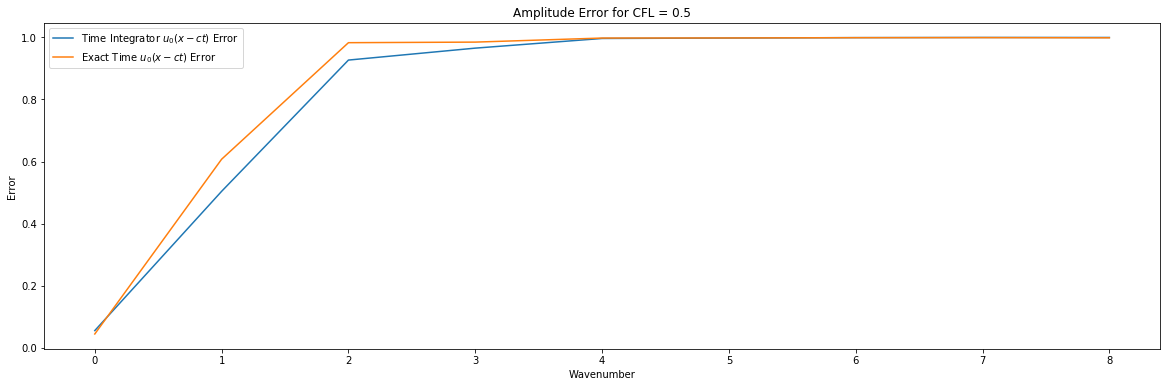

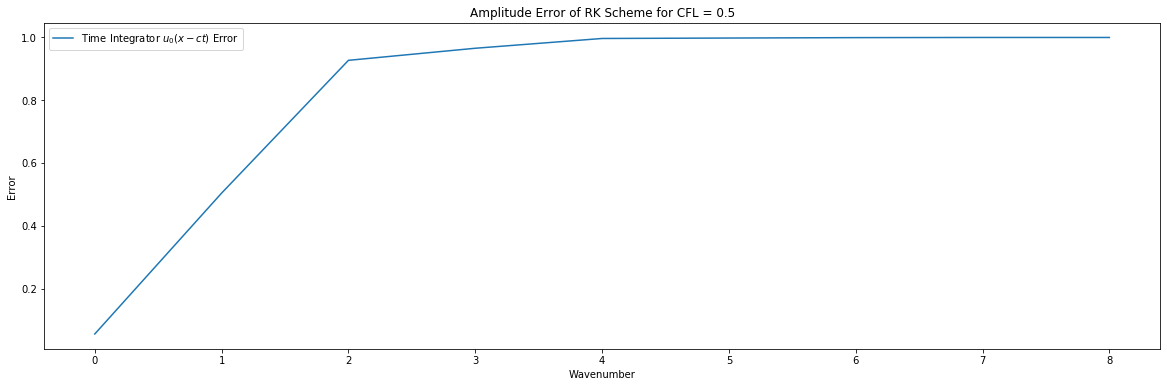

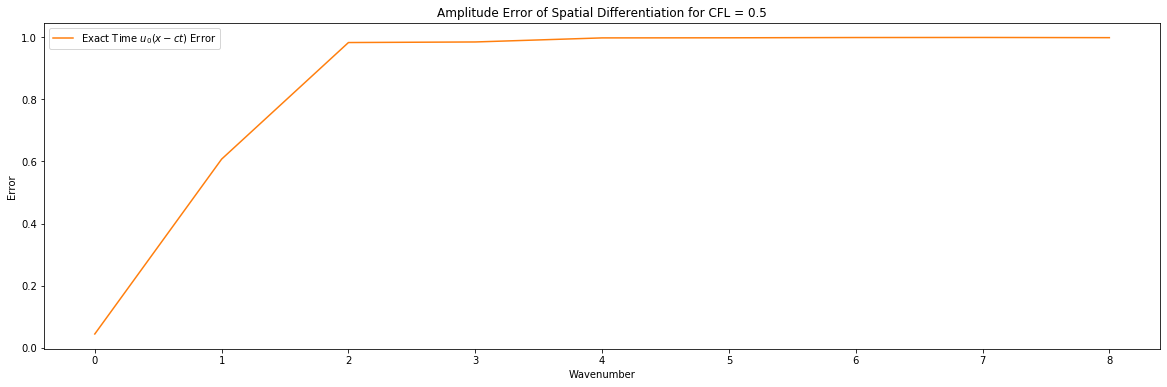

In [8]:
print(len(solverCoefs[1::2][:-1]))
print(len(solverCoefs[::2][1:]))
print(len(propFCoefs[1::2][:-1]))
print(len(propFCoefs[::2][1:]))
ampKs, solverError = TT.AmpError(omega, nullspace @ propFCoefs, nullspace @ solverCoefs)
ampKs, exTimeError = TT.AmpError(omega, nullspace @ propFCoefs, nullspace @ exTimeCoefs)
ks, error = TT.CalcError(omega, nullspace @ propFCoefs, nullspace @ solverCoefs, errorType = 'relative')
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, solverError, label = labels[3] + ' Error', color = PT.ColorDefault(0))
plt.plot(ampKs, exTimeError, label = labels[2] + ' Error', color = PT.ColorDefault(1))
plt.title('Amplitude Error for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, solverError, label = labels[3] + ' Error', color = PT.ColorDefault(0))
plt.title('Amplitude Error of RK Scheme for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ampKs, exTimeError, label = labels[2] + ' Error', color = PT.ColorDefault(1))
plt.title('Amplitude Error of Spatial Differentiation for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
plt.show()

In [9]:
print(GTT.MakeLinearInterp(8))

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [11]:
# A is the main diagonal; C is the subdiagonal; G is the sub-subdiagonal; E is the superdiagonal; H is the super-superdiagonal.
n = omega.degFreed
hs = omega.h
A = hs - np.roll(hs, 1)
B = A + 0
F = np.roll(A, -1)
F[F > 0] = 1. / 3.
F[F != 1. / 3.] = 0
A[A < 0] = -1. / 3.
A[A != -1. / 3.] = 0
A = A - F
B[B > 0] = 0.5
B[B < 0] = 2. / 3.
C = -np.roll(B, -1)
B[B < 2. / 3.] = 1.
C[C == 0] = -1.
D = np.roll(C, -1)
D[D != -0.5] = 0
E = -C
E[E == 0.5] = 4. /3.
E[E == 2. / 3.] = 0.5
G = np.roll(C, -1)
G[G != -0.5] = 0
H = E + 0
H[H != 0.5] = 0
Deriv = np.zeros((n, n), float)
np.fill_diagonal(Deriv, A)
np.fill_diagonal(Deriv[1:], C)
np.fill_diagonal(Deriv[:, 1:], E)
np.fill_diagonal(Deriv[2:], G)
np.fill_diagonal(Deriv[:, 2:], H)
Deriv[0, n - 1] = C[::-1][0]
Deriv[0, n - 2] = G[::-1][1]
Deriv[1, n - 1] = G[::-1][0]

Deriv[n - 1, 0] = E[::-1][0]
Deriv[n - 2, 0] = H[::-1][1]
Deriv[n - 1, 1] = H[::-1][0]
hMat = OT.StepMatrix(omega)
# print(hMat)
# print('')
print(Deriv)

[[ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.         -0.5        -0.5       ]
 [-1.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.         -1.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.         -1.          0.          0.5         0.5         0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.66666667 -0.33333333  1.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.          0.          1.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -1.          0.          1.          0.          0.     